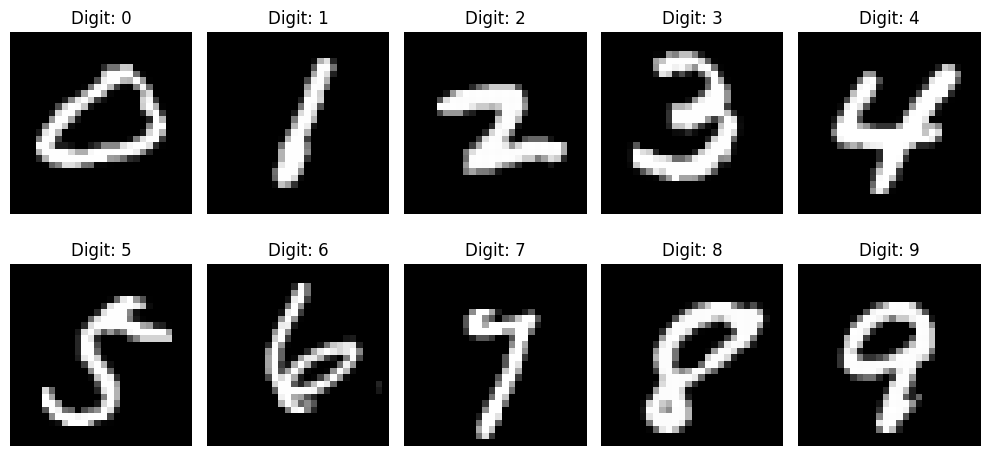

In [ ]:
# 1 a
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
import numpy as np

# Here we are loading the MNIST Dataset
mnist = fetch_openml('mnist_784', version=1)
Xraw, Yraw = mnist['data'], mnist['target']

# Here we are conerting to integers as they are in string format
Yraw = Yraw.astype(np.int8)



fig, axs = plt.subplots(2, 5, figsize=(10, 5))
axs = axs.ravel()  # Flatten the axes array for easier indexing

# Here Iterate through digits 0 to 9 and plot one random example for each
for digit in range(10):
    # Find all indices where the current digit is present
    digit_where = np.where(Yraw == digit)[0]

    # Randomly select one index
    random_index = np.random.choice(digit_where)

    # Access data using .iloc[] to ensure consistent indexing between Xraw and Yraw
    image = Xraw.iloc[random_index].values.reshape(28, 28)

    # Plot the image
    axs[digit].imshow(image, cmap='gray')
    axs[digit].set_title(f"Digit: {digit}")
    axs[digit].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# 1 b
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import OneHotEncoder

# Load the MNIST dataset
mnist = fetch_openml('mnist_784', version=1)
Xraw, Yraw = mnist['data'], mnist['target']

# Convert the labels to integers
Yraw = Yraw.astype(np.int8)

# Set the dimension for the random feature extractor
d = 10

# Create a random feature extractor matrix M
# Entries are drawn from a uniform distribution and normalized
M = np.random.uniform(0, 1, (d, 784)) / (255 * d)

# Project the raw features into a lower-dimensional space
X_projected = M @ Xraw.T  # Shape will be (d, 70,000)

# One-hot encode the labels
one_hot_encoder = OneHotEncoder(sparse_output=False, categories='auto')
Y_one_hot = one_hot_encoder.fit_transform(Yraw.values.reshape(-1, 1)).T  # Shape will be (10, 70,000)

# Calculate the Moore-Penrose pseudoinverse to find the best weights
X_pseudo_inv = np.linalg.pinv(X_projected.T)  # Shape will be (70,000, d)
W = X_pseudo_inv @ Y_one_hot.T  # W will be of shape (d, 10)

# Print the shape of the weight matrix
print("Shape of weight matrix W:", W.shape)  # Should be (300, 10)


Shape of weight matrix W: (10, 10)


In [ ]:
# 1 c
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error

# Load the MNIST dataset
mnist = fetch_openml('mnist_784', version=1)
Xraw, Yraw = mnist['data'], mnist['target']
Yraw = Yraw.astype(np.int8)

# One-hot encode the labels
one_hot_encoder = OneHotEncoder(sparse_output=False, categories='auto')
values = Yraw.values
reshaped_values = values.reshape(-1, 1)
Y_one_hot = one_hot_encoder.fit_transform(reshaped_values).T

# Function to calculate MSE and mistakes for different values of d
def compute_metrics(d):
    M = np.random.uniform(0, 1, (d, 784)) / (255 * d)
    X_projected = M @ Xraw.T
    X_pseudo_inv = np.linalg.pinv(X_projected.T)
    W = X_pseudo_inv @ Y_one_hot.T
    Y_pred = W.T @ X_projected
    mse = mean_squared_error(Y_one_hot.T, Y_pred.T)

    predicted_labels = np.argmax(Y_pred, axis=0)
    true_labels = np.argmax(Y_one_hot, axis=0)
    mistakes = np.sum(predicted_labels != true_labels)

    return mse, mistakes

# Set the values of d to test
d_values = [10, 50, 100, 200, 500]

# Dictionary to store results for each d
results = {}

# Compute the metrics for each value of d
for d in d_values:
    mse, mistakes = compute_metrics(d)
    results[d] = {'MSE': mse, 'Mistakes': mistakes}

# Print the results separately for each value of d
for d, metrics in results.items():
    print(f"Results for d = {d}:")
    print(f"MSE: {metrics['MSE']:.6f}")
    print(f"Mistakes: {metrics['Mistakes']}")
    print("---------------")

# Calculate and print random guessing baseline
random_guessing_mistakes = 70000 * (9 / 10)  # If we guess randomly, we are wrong 9/10 times
print(f"Random guessing mistakes (baseline): {random_guessing_mistakes}")


Results for d = 10:
MSE: 0.074273
Mistakes: 34659
---------------
Results for d = 50:
MSE: 0.053615
Mistakes: 15704
---------------
Results for d = 100:
MSE: 0.046504
Mistakes: 12457
---------------
Results for d = 200:
MSE: 0.042234
Mistakes: 10916
---------------
Results for d = 500:
MSE: 0.039402
Mistakes: 10380
---------------
Random guessing mistakes (baseline): 63000.0


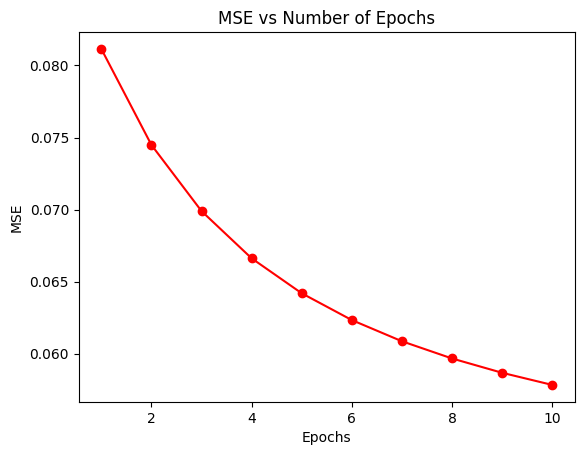

In [ ]:
# 1 d
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import pandas as pd

# Load the MNIST dataset
mnist = fetch_openml('mnist_784', version=1)
Xraw, Yraw = mnist['data'], mnist['target']
Yraw = Yraw.astype(np.int8)

# One-hot encode the labels
one_hot_encoder = OneHotEncoder(sparse_output=False, categories='auto')
Y_one_hot = one_hot_encoder.fit_transform(Yraw.values.reshape(-1, 1)).T

# Create a random feature extractor (M matrix)
def create_random_feature_extractor(d):
    M = np.random.uniform(0, 1, (d, 784)) / (255 * d)
    return M

# Project the original dataset into a lower-dimensional space
def project_features(M, Xraw):
    X_projected = M @ Xraw.T
    return X_projected

# LMS algorithm to update weights and minimize error
def lms_algorithm(X_projected, Y_one_hot, d, eta, epochs):
    n_samples = X_projected.shape[1]
    W = np.zeros((d, 10))  # Initialize weights matrix
    mse_history = []

    if isinstance(X_projected, pd.DataFrame):
        X_projected = X_projected.values

    for epoch in range(epochs):
        for i in range(n_samples):
            x_i = X_projected[:, i]  # Feature vector for each sample
            y_i = Y_one_hot[:, i]    # One-hot encoded true label

            # Make predictions and update weights
            y_pred = W.T @ x_i
            W += eta * np.outer(x_i, (y_i - y_pred))

        # Calculate the mean squared error after each epoch
        Y_pred = W.T @ X_projected
        mse = mean_squared_error(Y_one_hot.T, Y_pred.T)
        mse_history.append(mse)

    return W, mse_history

# Function to compute the number of mistakes (classification errors)
def compute_mistakes(Y_pred, Y_one_hot):
    predicted_labels = np.argmax(Y_pred, axis=0)  # Predicted labels
    true_labels = np.argmax(Y_one_hot, axis=0)    # Actual labels
    mistakes = np.sum(predicted_labels != true_labels)
    return mistakes

# Set parameters
d = 100  # Number of dimensions to reduce to
eta = 0.001  # Learning rate for weight updates
epochs = 10  # Number of training iterations

# Generate random feature extractor
M = create_random_feature_extractor(d)

# Project the original data using M
X_projected = project_features(M, Xraw)

# Run the LMS algorithm and track MSE across epochs
W_lms, mse_history = lms_algorithm(X_projected, Y_one_hot, d, eta, epochs)

# Plot MSE over epochs
plt.plot(range(1, epochs + 1), mse_history, marker='o', color='red')
plt.title('MSE vs Number of Epochs')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.show()
